In [155]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import activations
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from math import *

# 1. Generate Data

(-7.06, 1313.2)
97


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


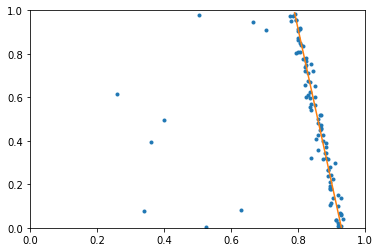

In [156]:
sigma_noise = [2, 2]
image_size = (200, 200)

def generate_line(image):
    a = int(random.uniform(-10, 10) * 100) / 100
    p = (np.random.randint(image[0]), np.random.randint(image[1]))
    b = p[1] - a*p[0]
    return (a, b)

def compute_line_from_points(p1, p2, image):
    x1, y1 = int(image[0]*p1[0]), int(image[1]*p1[1])
    x2, y2 = int(image[0]*p2[0]), int(image[1]*p2[1])
    if (x2-x1) != 0:
        a = int((y2-y1)/(x2-x1) * 100) / 100
    else:
        a = 100
    b = y1 - a*x1
    return (a, b)
    

def generate_data(line, image, sigma, n_inliers, n_outliers):
    a, b = line
    L_X = []
    L_Y = []
    Points = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            p = np.array([x, y])
            Points.append(p)
    covariance = np.diag(np.array(sigma) ** 2)
    n_i = max(1, n_inliers // len(Points))
    for point in Points:
        sample = np.random.multivariate_normal(point, covariance, n_i)
        sample_X = map(lambda x: int(x)/image[0], sample[:, 0])
        sample_Y = map(lambda x: int(x)/image[1], sample[:, 1])
        L_X.extend(sample_X)
        L_Y.extend(sample_Y)
    
    for k in range(n_outliers):
        (x, y) = (np.random.randint(image[0])/image[0], np.random.randint(image[1])/image[1])
        L_X.append(x)
        L_Y.append(y)
    
    return (L_X, L_Y)

def plot_data(D, ax, c=None):
    L_x, L_y = D
    ax.plot(L_x, L_y, '.', c=c)

def plot_line(line, image, ax, c=None):
    a, b = line
    X = []
    Y = []
    for x in range(image[0]):
        y = a*x+b
        if y >= 0 and y < image[1]:
            X.append(x/image[0])
            Y.append(y/image[1])
    ax.plot(X, Y, c=c)
    
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line = generate_line(image_size)
print(line)
D = generate_data(line, image_size, sigma_noise, 100, 10)
plot_data(D, ax)
plot_line(line, image_size, ax)
fig.show()
#print(D)
print(len(D[0]))

### Loss between 2 lines

(-1.38, 255.77999999999997)
(9.63, -388.6500000000001)
26937
13063
True
area final =  0.6734249999999999


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


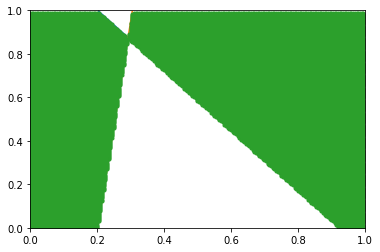

In [157]:
def point_y_in_image(l, x, image_y):
    a, b = l
    y = int(a*x+b)
    y = min(max(y, 0), image_y-1)
    return y

def intersect(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    if a1 == a2:
        return False
    else:
        x = (b2 - b1)/(a1-a2)
        y = a1*x+b1
        if x >= 0 and x < image[0] and y >= 0 and y < image[1]:
            return True
        else:
            return False

def change_sign(l1, l2, image):
    a1, b1 = l1
    a2, b2 = l2
    d1 = b1 - b2
    x = image[0]
    d2 = (a1*x+b1)-(a2*x+b2)
    if d1*d2 < 0:
        return True
    else:
        return False

def loss_weights(l1, l2, image):
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
    area2 = image[0]*image[1] - area1
    
    inter = intersect(l1, l2, image)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1
    #print("area final = ", area)
    area = 1 - (area/(image[0]*image[1]))
    return area

def plot_loss(l1, l2, image, ax):
    plot_line(l1, image_size, ax)
    plot_line(l2, image_size, ax)
    area_X = []
    area_Y = []
    area1 = 0
    for x in range(image[0]):
        y1 = point_y_in_image(l1, x, image[1])
        y2 = point_y_in_image(l2, x, image[1])
        area1 += abs(y1-y2)
        for k in range(min(y1, y2), max(y1, y2)):
            area_X.append(x/image[0])
            area_Y.append(k/image[1])
    ax.plot(area_X, area_Y, '.')
    print(area1)
    area2 = image[0]*image[1] - area1
    print(area2)
    
    inter = intersect(l1, l2, image)
    print(inter)
    if inter :
        area = min(area1, area2)
    else:
        sign = change_sign(l1, l2, image)
        print(sign)
        if l1[0]*l2[0] <=0 and sign:
            area = area2
        else:
            area = area1

    area = 1 - (area/(image[0]*image[1])) 
    print("area final = ", area)

    fig.show()

fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
line1 = generate_line(image_size)
print(line1)

line2 = generate_line(image_size)
print(line2)
plot_loss(line1, line2, image_size, ax)

### Neural network model

In [158]:
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(1024)
        self.bn_4 = nn.BatchNorm1d(512)
        self.bn_5 = nn.BatchNorm1d(256)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]

        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x

class BasePointNet(nn.Module):

    def __init__(self, point_dimension, return_local_features=False):
        super(BasePointNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)

        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 1024, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(1024)

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 1024)

        if self.return_local_features:
            x = x.view(-1, 1024, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform

class FeaturesPointNet(nn.Module):

    def __init__(self, dropout, point_dimension):
        super(FeaturesPointNet, self).__init__()
        self.base_pointnet = BasePointNet(return_local_features=False, point_dimension=point_dimension)

        self.fc_1 = nn.Linear(1024, 512)
        self.fc_2 = nn.Linear(512, 256)
        #self.fc_3 = nn.Linear(256, num_classes)

        self.bn_1 = nn.BatchNorm1d(512)
        self.bn_2 = nn.BatchNorm1d(256)

        self.dropout_1 = nn.Dropout(dropout)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)

        x = F.relu(self.bn_1(self.fc_1(x)))
        x = F.relu(self.bn_2(self.fc_2(x)))
        x = self.dropout_1(x)

        #return F.log_softmax(self.fc_3(x), dim=1), feature_transform
        return x, feature_transform


class Weights(nn.Module):

    
    def __init__(self, dropout=0.3, point_dimension=2):
        super(Weights, self).__init__()
        self.point1 = FeaturesPointNet(dropout, point_dimension)
        self.point2 = FeaturesPointNet(dropout, point_dimension)

        self.fc_1 = nn.Linear(518, 1)
        
        
    def forward(self, x):
        #print(x.shape)
        n = (x.shape[1] - 3)//2
        x1 = x[:, :n]
        x2 = x[:, n:2*n]
        v = x[:, 2*n]
        p1 = x[:, 2*n+1]
        p2 = x[:, 2*n+2]
        #print("x1.shape= ", x1.shape)
        #print("x2.shape= ", x2.shape)
        #print("v.shape = ", v.shape)
        
        assert 2*n+2==x.shape[1]-1
        
        x1, feature_transform1 = self.point1(x1)
        x2, feature_transform2 = self.point2(x2)
        #print("feature1.shape = ", x1.shape)
        #print("feature2.shape = ", x2.shape)
        #print(feature_transform1.shape)
        
        x_tot = torch.cat((x1, x2), dim=1)
        #print("x_tot.shape = ", x_tot.shape)

        x = torch.cat((x_tot, v), dim=1)
        x = torch.cat((x, p1), dim=1)
        x = torch.cat((x, p2), dim=1)

        #print("x.shape = ", x.shape)
        #print("x = ", x)
        
        x = F.relu(self.fc_1(x))

        return x #, feature_transform


In [159]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return sqrt((x1-x2)**2+(y1-y2)**2)

def reorder(L, M):
    p = L[-1]
    d = M[-1]
    k = len(L) - 2
    while k >= 0 and M[k] > d:
        L[k+1] = L[k]
        M[k+1] = M[k]
        k -= 1
    L[k+1] = p
    M[k+1] = d

def nearest_neighbors(data, i, k):
    p = (data[0][i], data[1][i])
    L = []
    M = []
    n = len(data[0])
    for j in range(n):
        (x, y) = (data[0][j], data[1][j])
        d = dist((x, y), p)
        if len(L) < k:
            L.append((x, y))
            M.append(d)
            reorder(L, M)
        else:
            d2 = M[-1]
            if d < d2:
                L[-1] = (x, y)
                M[-1] = d
                reorder(L, M)
    return L

In [160]:
def center_points(points, p):
    (x, y) = p
    L = []
    for point in points:
        (xp, yp) = point
        L.append([xp-x, yp-y])
    return L

def compute_features(data, i1, i2):
    p2 = (data[0][i2], data[1][i2])
    p1 = (data[0][i1], data[1][i1])
    vec = [p2[0]-p1[0], p2[1]-p1[0]]
    k = 10
    x1 = center_points(nearest_neighbors(data, i1, k), p1)
    x2 = center_points(nearest_neighbors(data, i2, k), p2)
    feature = x1+x2
    feature.append(vec)
    feature.append([p1[0], p1[1]])
    feature.append([p2[0], p2[1]])
    return feature
    

def generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers):
    Lines = []
    Datas = []
    X = []
    Y = []
    for k in range(nbr):
        line_ref = generate_line(image)
        Lines.append(line_ref)
        data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
        Datas.append(data)
        nbr_points = len(data[0])
        for i in range(int(sqrt(nbr_per_line))):
            i1 = np.random.randint(nbr_points)
            for i in range(int(sqrt(nbr_per_line))):
                i2 = np.random.randint(nbr_points)
                while i2 == i1:
                    i2 = np.random.randint(nbr_points)
                feature=compute_features(data, i1, i2)
                X.append(feature)
                p2 = (data[0][i2], data[1][i2])
                p1 = (data[0][i1], data[1][i1])
                line = compute_line_from_points(p1, p2, image)
                area = loss_weights(line_ref, line, image)
                Y.append(area)
    #print(type(X))
    X_tensor = torch.Tensor(X)
    Y_tensor = torch.Tensor(Y)
    #print(type(X_tensor))
    #print(X_tensor.shape)
    return (X_tensor, Y_tensor)

def split_training(xy, prop=0.1):
    (X, Y) = xy
    k = int(prop*len(X))
    x_test = X[:k]
    y_test = Y[:k]
    x_train = X[k:]
    y_train = Y[k:]
    return ((x_test, y_test), (x_train, y_train))

In [165]:
model = Weights()

sigma_noise = [2, 2]
image_size = (200, 200)


In [166]:
def train_model(model, image, sigma, nbr, nbr_per_line, nbr_inliers=100, nbr_outliers=10):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line, nbr_inliers, nbr_outliers))
    #print(x_test, y_test)
    #print(x_train, y_train)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.00001)
    print("data generated")
    
    # Train step
    nbr_step = 50
    for k in range(nbr_step):
        model.train()  # <-- here
        optimizer.zero_grad()

        y_predict = model(x_train)
        loss = loss_fn(y_predict, y_train)

        loss.backward()
        optimizer.step()

        # Eval
        model.eval()  # <-- here
        with torch.no_grad():
            y_predict_eval = model(x_test)
            loss_eval = loss_fn(y_predict_eval, y_test)

        print("iteration = ", k+1, " ; loss_train = ", loss.item(), " ; loss_eval = ", loss_eval.item())
        
        if k == nbr_step - 1:
            last_weight = y_predict_eval
            print(y_predict_eval)
            
    return model

model_trained = train_model(model, image_size, sigma_noise, 20, 100, nbr_inliers=150, nbr_outliers=30)



data generated
iteration =  1  ; loss_train =  0.7990270256996155  ; loss_eval =  0.788921594619751
iteration =  2  ; loss_train =  0.8003585338592529  ; loss_eval =  0.788921594619751
iteration =  3  ; loss_train =  0.7952213883399963  ; loss_eval =  0.788921594619751
iteration =  4  ; loss_train =  0.7989047169685364  ; loss_eval =  0.788921594619751
iteration =  5  ; loss_train =  0.7954508066177368  ; loss_eval =  0.788921594619751
iteration =  6  ; loss_train =  0.7940080761909485  ; loss_eval =  0.788921594619751
iteration =  7  ; loss_train =  0.7925904393196106  ; loss_eval =  0.788921594619751
iteration =  8  ; loss_train =  0.7954609394073486  ; loss_eval =  0.788921594619751
iteration =  9  ; loss_train =  0.791562020778656  ; loss_eval =  0.788921594619751
iteration =  10  ; loss_train =  0.7937518358230591  ; loss_eval =  0.788921594619751
iteration =  11  ; loss_train =  0.7907098531723022  ; loss_eval =  0.788921594619751
iteration =  12  ; loss_train =  0.79239988327026

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


tensor([0.0068]) tensor([0.])
(0.19, 0.215)
[0.999775] [0.550025]
(0.19, 0.215)
tensor([0.0109]) tensor([0.])
(0.21, 0.07)
[0.999525] [0.53915]
(0.21, 0.07)
tensor([0.0126]) tensor([0.])
(0.195, 0.03)
[0.991925] [0.5365500000000001]
(0.195, 0.03)
tensor([0.]) tensor([0.])
(0.11, 0.85)
[0.9996] [0.545625]
(0.11, 0.85)
tensor([0.]) tensor([0.])
(0.155, 0.495)
[0.999775] [0.5180750000000001]
(0.155, 0.495)


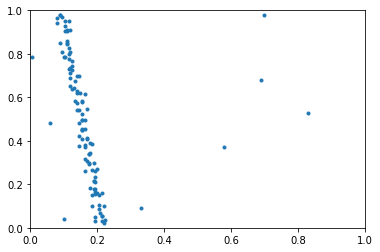

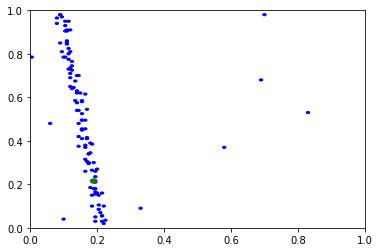

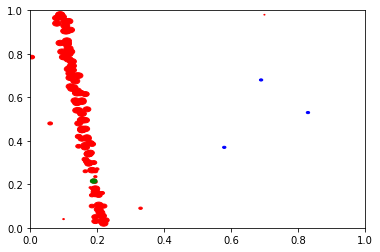

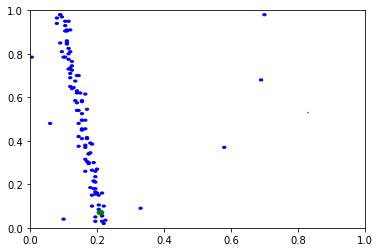

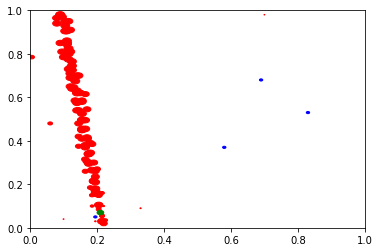

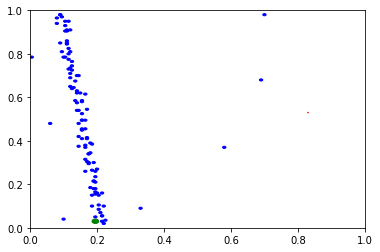

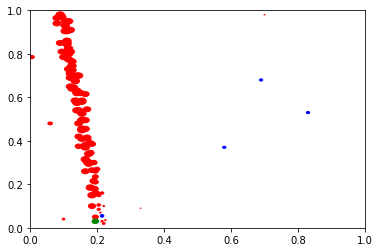

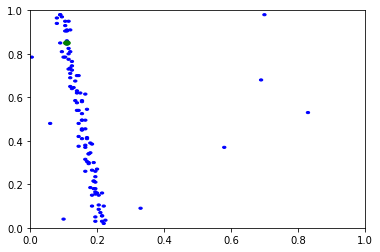

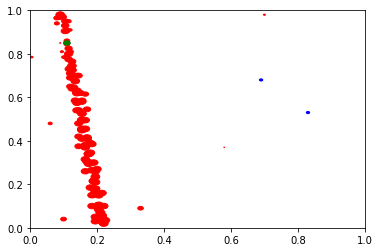

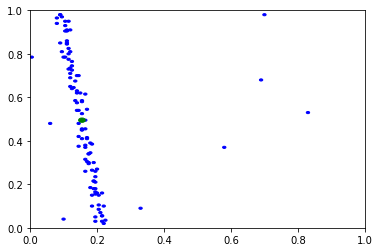

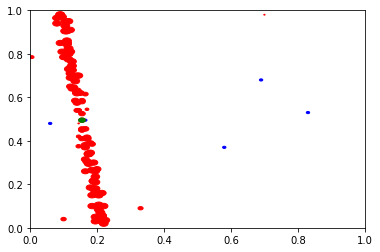

In [168]:
def plot_weights(weights, coord, p1, image, ref=False):
    print(max(weights), min(weights))
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    n = len(weights)

    for i in range(n):
        (x, y) = coord[i]
        w = weights[i][0]
        r = (exp(10*w)/exp(7))
        if ref:
            r = exp(8*w)/exp(7)/image[0]
        circle = plt.Circle((x, y), r, color='r')
        if r <= 10**(-3):
            circle = plt.Circle((x, y), 1./image[0], color='b')

        ax.add_artist(circle)
    print(p1)
    circle_1 = plt.Circle(p1, 2./image[0], color='g')
    ax.add_artist(circle_1)
    fig.show()
    

def test_nn(model, image, sigma, nbr_inliers=100, nbr_outliers=10):
    line_ref = generate_line(image)
    data = generate_data(line_ref, image, sigma, nbr_inliers, nbr_outliers)
    n = len(data[0])

    fig, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plot_data(data, ax)
    fig.show()
    
    
    for it in range(5):
        i1 = np.random.randint(n)
        X = []
        coord = []
        weights_ref = []
        p1 = (data[0][i1], data[1][i1])
        for i2 in range(n):
            if i2!=i1:
                feature=compute_features(data, i1, i2)
                X.append(feature)
                X_tensor = torch.Tensor(X)
                  
                
                p2 = (data[0][i2], data[1][i2])
                line = compute_line_from_points(p1, p2, image)
                area = loss_weights(line_ref, line, image)
                weights_ref.append([area])
                
                coord.append((data[0][i2], data[1][i2]))

        model.eval()
        with torch.no_grad():
            weights = model(X_tensor)
        
        plot_weights(weights, coord, p1, image)
        plot_weights(weights_ref, coord, p1, image, ref=True)

test_nn(model, image_size, sigma_noise)

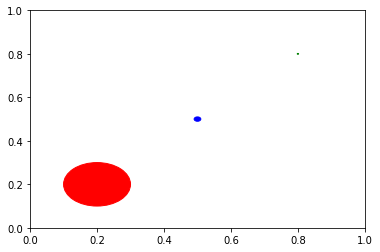

In [142]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


for i in range(3):
    if i == 0:
        circle = plt.Circle((0.2, 0.2), 10**(-1), color='r')
    elif i == 1:
        circle = plt.Circle((0.5, 0.5), 10**(-2), color='blue')
    else:
        circle = plt.Circle((0.8, 0.8), 2*10**(-3), color='g', clip_on=False)
    ax.add_artist(circle)


fig.savefig('plotcircles.png')

In [596]:
py_list = [[[1.,2.] , [3.,4.]],[[5.,6.], [7.,8.]],[[9.,10.], [11.,12.]]]
#print(type(py_list))
pt_tensor_from_list = torch.FloatTensor(py_list)
#print(type(pt_tensor_from_list))
#print(pt_tensor_from_list)
#print(pt_tensor_from_list.shape)

pt_split = pt_tensor_from_list[:, :1, :]
#print(pt_split)
#print(pt_split.shape)

l = [[[2, 3]], [[3, 4]], [[5, 6]]]
t = torch.Tensor(l)
print(t.shape)
t2 = t.resize(3, 2)
print(t2)
print(t2.shape)


torch.Size([3, 1, 2])
tensor([[2., 3.],
        [3., 4.],
        [5., 6.]])
torch.Size([3, 2])


C:\ProgramData\Anaconda3\lib\site-packages\torch\tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [362]:
def train_model(image, sigma, nbr, nbr_per_line, batch_size=32, epochs=5):
    ((x_test, y_test), (x_train, y_train)) = split_training(generate_training_data(image, sigma, nbr, nbr_per_line))
    input_shape = (2, 2, 2)
    model = Network(input_shape, batch_size=batch_size, epochs=epochs)
    print("training...", end='')
    model.train_nn(x_train, y_train, x_test, y_test)
    print("done")
    return model




### Compute weights from model

In [363]:
def compute_weights(model, data, i1):
    weights = []
    n = len(data[0])
    
    print(data)
    p1 = data[0][i1], data[1][i1]
    for i2 in range(n):
        if i2==i1:
            weights.append(0)
        else:
            features = compute_features(data, i1, i2)
            p2 = data[0][i2], data[1][i2]
            w = model.predict(features)
            weights.append(w)
    return weights

def sample_from_weights(data, weights, sample, sigma=5):
    n = len(data[0])
    m = 1
    if len(sample) == 0:
        x1 = np.random.randint(n)
        for k in range(1000):
            x2 = int(np.random.normal(loc=x2, scale=sigma))
            alpha = weights[x2]/weights[x1]
            u = random.uniform(0, 1)
            if u <= alpha:
                x1 = x2
    else:
        x1 = sample[-1]
    
    for k in range(m):
        x2 = int(np.random.normal(loc=x2, scale=sigma))
        alpha = weights[x2]/weights[x1]
        u = random.uniform(0, 1)
        if u <= alpha:
            x1 = x2
        sample.append(x1)


### Ransac

In [365]:
def get_inliers(data, line, threshold):
    a, b = line
    X, Y = data
    Inliers = []
    for x in X:
        if abs((a*x+b) - y) < threshold:
            Inliers.append((x, y))
    return Inliers

def get_model(model, data, image, sample):
    n = len(data[0])
    i1 = np.random.randint(n)
    weights = compute_weights(model, data, i1)
    sample_from_weights(data, weights, sample)
    i2 = sample[-1]
    p1 = data[0][i1], data[1][i1]
    p2 = data[0][i2], data[1][i2]
    line = compute_line_from_points(p1, p2, image)
    return line


def update_stopping_criterion(k, inliers, proba):
    if k > 100:
        return true
    return false


def ransac(model, data, threshold, image, proba):
    k = 0
    inliers_max = []
    line_max = None
    end = False
    while not end:
        sample = []
        line = get_model(model, data, image, sample)
        inliers = get_inliers(data, line, threshold)
        if len(inliers) > len(inliers_max):
            inliers_max = inliers
            line_max = line
        k += 1
        end = update_stopping_criterion(k, inliers, proba)
    return line_max

### Full test

In [366]:
def test(image, sigma):
    line = generate_line(image)
    data = generate_data(line, image, sigma)
    
    nbr = 50
    nbr_per_line = 100
    model = train_model(image, sigma, nbr, nbr_per_line)
    
    line_predict = ransac(model, data, 3, image, 0.1)
    
    fig, ax = plt.subplots()
    ax.set_xlim(0, image[0])
    ax.set_ylim(0, image[1])
    plot_data(data, ax)
    plot_line(line, image, ax)
    plot_line(line_predict, image, ax)
    fig.show()
    
    return line_predict

test(image_size, sigma)



ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv2d_6/convolution' (op: 'Conv2D') with input shapes: [?,2,2,2], [3,3,2,32].